In [1]:
import sys
import numpy as np
from pathlib import Path
parent_dir = Path.cwd().parent.parent
sys.path.append(str(parent_dir))
from instruments import *
from physical_models import *
from matplotlib.ticker import MultipleLocator
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 16,
    "lines.linewidth": 3,
})


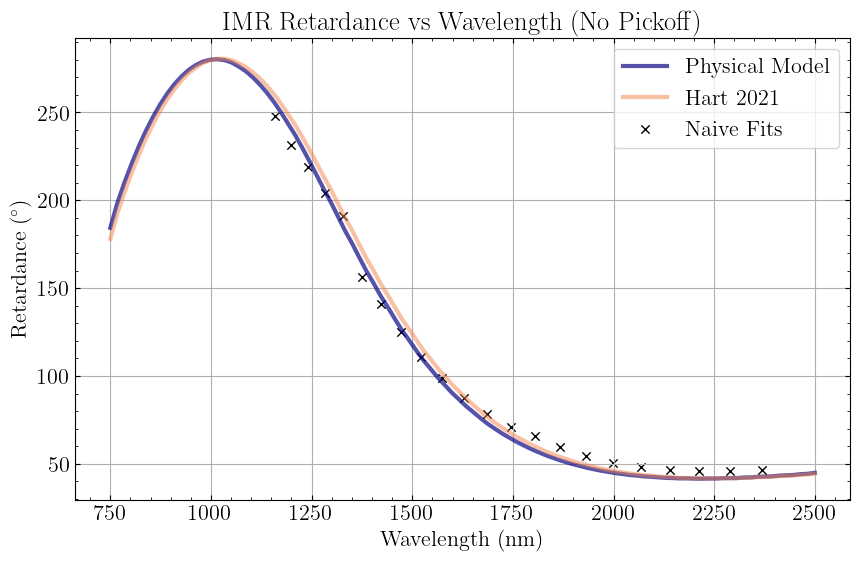

In [55]:
# Use results from minimization to make imr plot

wsio2, wmgf2, d = [1.64609, 1.28551, 259.11004]
hart = [1.623,1.268,262.56]
nodegen = [1.622, 1.268, 259.5]
wavelengths = np.linspace(750,2500,100)
json_dir = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/system_dicts_with_pickoff_cal')
params,fig,ax = plot_config_dict_vs_wavelength('image_rotator', 'phi',json_dir, title= 'IMR Retardance vs Wavelength (No Pickoff)', axtitle='Retardance ($^{\circ}$)')
cmap = plt.get_cmap('plasma')
ax.plot(wavelengths,np.rad2deg(IMR_retardance(wavelengths,d)), color=cmap(0.0), alpha = 0.7, label = 'Physical Model')
#ax.plot(wavelengths,np.rad2deg(IMR_retardance(wavelengths,nodegen[2])), color=cmap(0.3), alpha = 0.5, label = 'Removed Degeneracy')
ax.plot(wavelengths,np.rad2deg(IMR_retardance(wavelengths,hart[2])), color=cmap(0.7), alpha = 0.5, label = 'Hart 2021')
ax.scatter([], [], marker='x',color='black' ,label='Naive Fits', linewidths=1)
ax.legend()
ax.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  
)
ax.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
ax.minorticks_on()
#plt.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/model_fitting/plots/imr_retardance_v_wavelength_nopick.png', bbox_inches='tight', dpi=600)


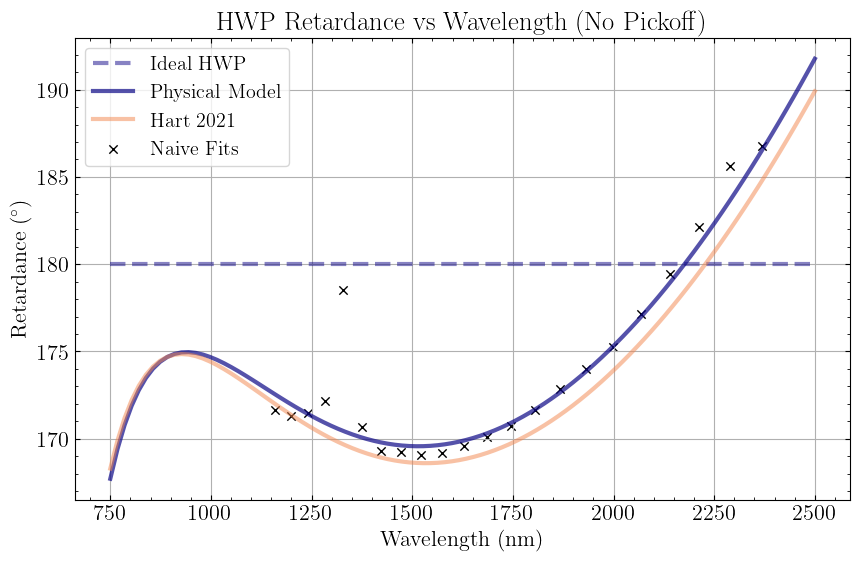

In [58]:
# now do hwp retardance

params,fig,ax = plot_config_dict_vs_wavelength('hwp', 'phi',json_dir, title= 'HWP Retardance vs Wavelength (No Pickoff)', axtitle='Retardance ($^{\circ}$)')
ax.plot(wavelengths, np.repeat(180, 100), color=cmap(1), alpha= 0.5,linestyle='--', label='Ideal HWP')
ax.plot(wavelengths, np.rad2deg(HWP_retardance(wavelengths, wsio2, wmgf2)), color=cmap(0), alpha=0.7, label='Physical Model')
#ax.plot(wavelengths,np.rad2deg(HWP_retardance(wavelengths,nodegen[0],nodegen[1])), color=cmap(0.3), alpha = 0.5, label = 'Removed Degeneracy')
ax.plot(wavelengths,np.rad2deg(HWP_retardance(wavelengths,hart[0],hart[1])), color=cmap(0.7), alpha = 0.5, label = 'Hart 2021')
ax.scatter([], [], marker='x', color='black', label='Naive Fits', linewidths=1)
ax.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  # both major and minor
)
ax.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)

# Show minor ticks
ax.minorticks_on()
plt.legend(fontsize=14.5)
plt.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/model_fitting/plots/hwp_retardance_v_wavelength_nopick.png', bbox_inches='tight', dpi=600)


Interleaved Values


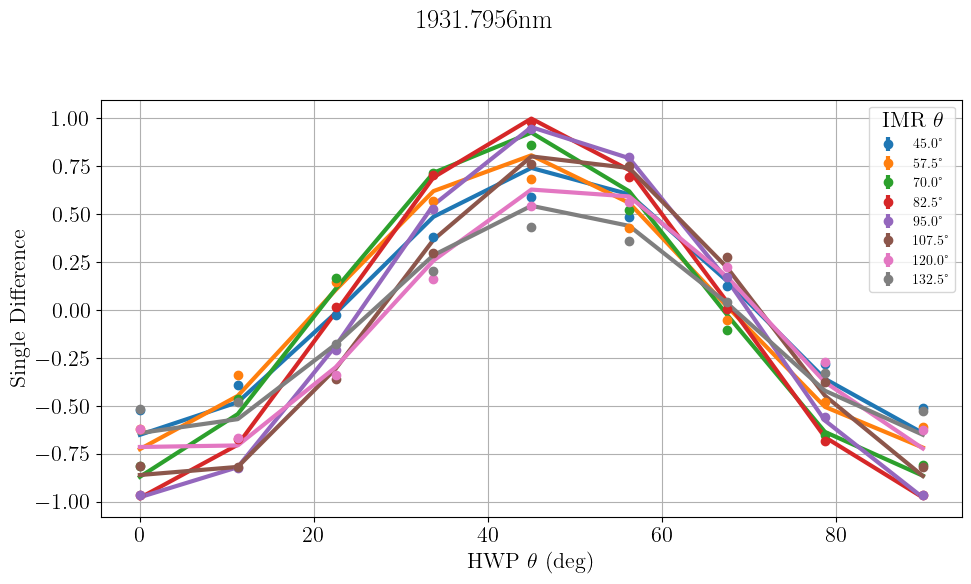

Residuals range: -0.15349213030819098 0.129174694147693


In [2]:
# Make a plot of the mcmc results
# Loading in MCMC fits

offset_imr = -0.27842 # derotator offset
offset_hwp = -2.09738 # HWP offset
offset_cal = -0.79060# calibration polarizer offset
imr_theta = 0
hwp_theta = 0

# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
        "components" : {
            "wollaston" : {
            "type" : "wollaston_prism_function",
            "properties" : {"beam": 'o'}, 
            "tag": "internal",
            },
            "image_rotator" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": imr_theta, "delta_theta": offset_imr},
                "tag": "internal",
            },
            "hwp" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": hwp_theta, "delta_theta": offset_hwp},
                "tag": "internal",
            },
            "lp" : {  # calibration polarizer for internal calibration source
                "type": "general_linear_polarizer_function_with_theta",
                "properties": {"delta_theta": offset_cal },
                "tag": "internal",
            }}
    }

# Converting system dictionary into system Mueller Matrix object

system_mm = generate_system_mueller_matrix(system_dict)

# Load in data
filepath = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin15_no_pickoff.csv')
interleaved_values, interleaved_stds, configuration_list = read_csv(filepath)
print("Interleaved Values")


# Get our model retardances from Joost t Hart physical models

p = [HWP_retardance(wavelength_bins)[15], IMR_retardance(wavelength_bins)[15]]


# Gefine what is in the p list

system_parameters = [['hwp', 'phi'], ['image_rotator', 'phi']]

# Generate our modeled left and right beam intensities

LR_intensities = model(p, system_parameters, system_mm, configuration_list)

# Process these into interleaved single norm differences and sums

diffs_sums = process_model(LR_intensities, 'CHARIS')

# Plot the modeled and observed values


plot_data_and_model(interleaved_values, interleaved_stds, diffs_sums,configuration_list, wavelength= wavelength_bins[15], mode='CHARIS',save_path='/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/model_fitting/plots/mcmcbin15.png')

# Print residuals (will be useful later to see if your fit improved at a quick glance)
residuals = interleaved_values[::2] - diffs_sums[::2]
print("Residuals range:", residuals.min(), residuals.max())


In [27]:
np.linspace(45,127.5,12)


array([ 45. ,  52.5,  60. ,  67.5,  75. ,  82.5,  90. ,  97.5, 105. ,
       112.5, 120. , 127.5])

In [52]:
nhwp = np.linspace(0,78.75,8)
8*12


96

Interleaved Values
Residuals range: -1.0290687412346475 0.8723879239832566


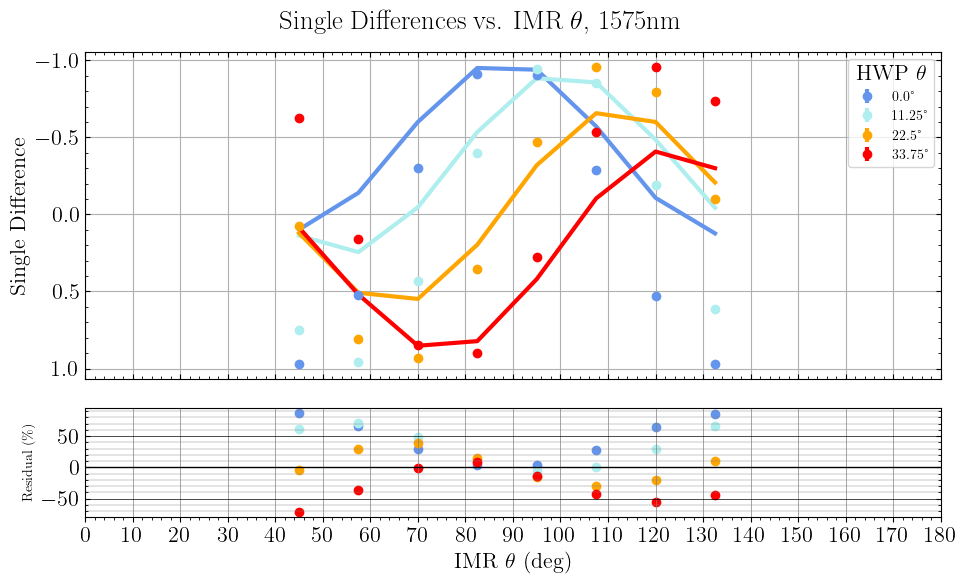

In [62]:
# Make a plot of the mcmc results
# Loading in naive fits

offset_imr = -0.25170 # derotator offset
offset_hwp = -1.55934 # HWP offset
offset_cal = 0.30446 # calibration polarizer offset
imr_theta = 0
hwp_theta = 0

# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
        "components" : {
            "wollaston" : {
            "type" : "wollaston_prism_function",
            "properties" : {"beam": 'o'}, 
            "tag": "internal",
            },
            "image_rotator" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": imr_theta, "delta_theta": offset_imr},
                "tag": "internal",
            },
            "hwp" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": hwp_theta, "delta_theta": offset_hwp},
                "tag": "internal",
            },
            "lp" : {  # calibration polarizer for internal calibration source
                "type": "diattenuator_retarder_function",
                "properties": {"epsilon":1,"delta_theta": offset_cal },
                "tag": "internal",
            }}
    }

# Converting system dictionary into system Mueller Matrix object

system_mm = generate_system_mueller_matrix(system_dict)

# Load in data
filepath = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin4_no_pickoff.csv')
interleaved_values, interleaved_stds, configuration_list = read_csv(filepath)
print("Interleaved Values")


# Get our model retardances from Joost t Hart physical models
wsio2_ = 1.65200
wmgf2_ = 1.28993
d_ = 259.15673
p = [HWP_retardance(wavelength_bins,wsio2_,wmgf2_)[9], IMR_retardance(wavelength_bins,d_)[9]]


# Gefine what is in the p list

system_parameters = [['hwp', 'phi'], ['image_rotator', 'phi']]

# Generate our modeled left and right beam intensities

LR_intensities = model(p, system_parameters, system_mm, configuration_list)

# Process these into interleaved single norm differences and sums

diffs_sums = process_model(LR_intensities, 'CHARIS')

# Plot the modeled and observed values


fig_imr, ax_imr,small_ax = plot_data_and_model_x_imr(interleaved_values, interleaved_stds, diffs_sums,configuration_list, hwp_theta_filter=[0,11.25,22.5,33.75],wavelength= wavelength_bins[9], title=r'Single Differences vs. IMR $\theta$, 1575nm')
ax_imr.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  # both major and minor
)
ax_imr.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
# Show minor ticks
ax_imr.minorticks_on()
ax_imr.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',
      # both major and minor
)
small_ax.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)




# Show minor ticks
small_ax.minorticks_on()
fig_imr.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/model_fitting/plots/MCMC_vs_imr_1575nm.png', bbox_inches='tight', dpi=600)


# Print residuals (will be useful later to see if your fit improved at a quick glance)
residuals = interleaved_values[::2] - diffs_sums[::2]
print("Residuals range:", residuals.min(), residuals.max())


In [40]:
def first_two_sigfigs(x):
    x = abs(x)
    while x >= 100:
        x //= 10
    while x < 10:
        x *= 10
    return int(x)
def bin_by_step(x, step=0.03):
    """
    Bins x to the nearest multiple of `step`, using centered bins.
    This prevents rounding artifacts and ensures consistency.
    """
    return round(x / step) * step

def write_fits_info_to_csv_hart(cube_directory_path, raw_cube_path, output_csv_path, wavelength_bin):
    """Write filepath, D_IMRANG (derotator angle), RET-ANG1 (HWP angle), 
    single sum, single difference, LCOUNTS, RCOUNTS, difference std,
    sum std, and wavelength values for a wavelength bin from each fits cube in the directory.
    Excludes redundant frames.

    FITS parameters are extracted from raw files, while single sum and difference are calculated using the
    fits cube data and the defined rectangular apertures.
    If the necessary header keywords are not present, the values will be set to NaN.

    Note - This function assumes that the raw and extracted cubes have the same number in the filepath. If
    you processed your cubes in the CHARIS DPP, this is not the case. 
    
    Parameters:
    -----------
    fits_directory_path : str or Path
        Path to the directory containing CHARIS fits cubes.
        
    raw_cube_path : str or Path
        Path to the directory containing the matching raw CHARIS FITS files.

    output_csv_path : str or Path
        Path where the output csv will be created.

    wavelength_bin : int
        Index of the wavelength bin to analyze (0-based).

    Returns:
    --------
    None
    """
    # check for valid file paths

    cube_directory_path = Path(cube_directory_path)
    raw_cube_path = Path(raw_cube_path)
    output_csv_path = Path(output_csv_path)

    if not cube_directory_path.is_dir():
        raise NotADirectoryError(f"Directory not found: {cube_directory_path}")
    if output_csv_path.suffix != '.csv':
        raise ValueError(f"Output path must be a CSV file, got {output_csv_path}")
    if not raw_cube_path.is_dir():
        raise NotADirectoryError(f"Raw cube directory does not exist: {raw_cube_path}")
    if wavelength_bin > 21:
        raise ValueError(f"This function is currently only compatible with lowres mode, with 22 wavelength bins.")
    
    # prepare output csv file

    output_csv_path = Path(output_csv_path)
    with open(output_csv_path, 'w') as f:
        f.write("filepath,D_IMRANG,RET-ANG1,single_sum,norm_single_diff,LCOUNTS,RCOUNTS,sum_std,diff_std,wavelength_bin\n")

        # iterate over all fits files in the directory
        previous_diff=previous_sum=None
        for fits_file in sorted(cube_directory_path.glob('*.fits')):
            try:

                # check if corresponding raw fits file exists
                 
                match = re.search(r"(\d{8})", fits_file.name)
                if not match:
                    raise ValueError(f"Could not extract 8-digit ID from filename {fits_file.name}")
                fits_id = match.group(1)
                raw_candidates = list(raw_cube_path.glob(f"*{fits_id}*.fits"))
                if not raw_candidates:
                    raise FileNotFoundError(f"No raw FITS file found for ID {fits_id}")
                raw_fits = raw_candidates[0]
                
                with fits.open(raw_fits) as hdul_raw:
                    raw_header = hdul_raw[0].header
                    d_imrang = raw_header.get("D_IMRANG", np.nan)
                    ret_ang1 = raw_header.get("RET-ANG1", np.nan)

                # round d_imrang to nearest 0.5
               
                d_imrang = (np.round(d_imrang * 2) / 2)

                # calculate single sum and normalized single difference

                single_sum, norm_single_diff, LCOUNTS, RCOUNTS, sum_std, diff_std = single_sum_and_diff(fits_file, wavelength_bin)
                rounded_norm_single_diff = bin_by_step(norm_single_diff)
                
                rounded_single_sum = first_two_sigfigs(single_sum)
                
                # wavelength bins for lowres mode

                bins = wavelength_bins
                
                # write to csv file
               # if previous_diff is None and previous_sum is None:
               #     f.write(f"{fits_file}, {d_imrang}, {ret_ang1}, {single_sum}, {norm_single_diff}, {LCOUNTS}, {RCOUNTS}, {sum_std}, {diff_std}, {bins[wavelength_bin]}\n")
              #      print(f"First CSV file written to {output_csv_path}")
              #      previous_diff = rounded_norm_single_diff
              #      previous_sum = rounded_single_sum
              #  else:
              #      if rounded_norm_single_diff==previous_diff and rounded_single_sum==previous_sum:
                #        print(f"Similar sums and differences detected. Skipping {fits_file.name} ")
                 #   else:
                f.write(f"{fits_file}, {d_imrang}, {ret_ang1}, {single_sum}, {norm_single_diff}, {LCOUNTS}, {RCOUNTS}, {sum_std}, {diff_std}, {bins[wavelength_bin]}\n")
                print(f"CSV file written to {output_csv_path}")
                 #       previous_diff = rounded_norm_single_diff
                 #       previous_sum = rounded_single_sum

            except Exception as e:
                print(f"Error processing {fits_file}: {e}")
    

In [43]:
for bin in range(0,22):
    write_fits_info_to_csv_hart('/Users/thomasmcintosh/Desktop/CHARIS-REU/hart/cubes','/Users/thomasmcintosh/Desktop/CHARIS-REU/hart/raw/2020-02-18',f'/Users/thomasmcintosh/Desktop/CHARIS-REU/hart/csvs_all/bin{bin}.csv',bin)

CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/hart/csvs_all/bin0.csv
Error processing /Users/thomasmcintosh/Desktop/CHARIS-REU/hart/cubes/CRSA00059592_cube.fits: No SIMPLE card found, this file does not appear to be a valid FITS file. If this is really a FITS file, try with ignore_missing_simple=True
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/hart/csvs_all/bin0.csv
Error processing /Users/thomasmcintosh/Desktop/CHARIS-REU/hart/cubes/CRSA00059594_cube.fits: No SIMPLE card found, this file does not appear to be a valid FITS file. If this is really a FITS file, try with ignore_missing_simple=True
CSV file written to /Users/thomasmcintosh/Desktop/CHARIS-REU/hart/csvs_all/bin0.csv
Error processing /Users/thomasmcintosh/Desktop/CHARIS-REU/hart/cubes/CRSA00059596_cube.fits: No SIMPLE card found, this file does not appear to be a valid FITS file. If this is really a FITS file, try with ignore_missing_simple=True
CSV file written to /Users/thomasmcintosh/Desktop

In [183]:
print(np.linspace(0,78.75,8))


[ 0.   11.25 22.5  33.75 45.   56.25 67.5  78.75]


In [69]:
def fix_hwp_angles_hart(csv_file_path, nderotator=10):
    '''Take corrupted HWP angles and replace them with assumed values
    in a new csv titled {old_title}_fixed. Works with Joost t Hart 2021 data.

    Parameters:
    -----------
    csv_file_path : str or Path
        Path to the specified CSV file containing the corrupted HWP angles.
    
    nderotator : int
        Number of derotator angles (assumed to be 8).
    Returns:
    --------
    None
    '''
    # check if csv_file_path is a valid file path

    csv_file_path = Path(csv_file_path)
    if not csv_file_path.is_file():
        raise FileNotFoundError(f"File not found: {csv_file_path}")
    
    # read csv file into pandas dataframe

    df = pd.read_csv(csv_file_path)

    # check if 'RET-ANG1' column is present

    if 'RET-ANG1' not in df.columns:
        raise ValueError("Column 'RET-ANG1' is missing from the CSV file.")
    
    hwp_angles = np.array([67.5,78.75,0,11.25,22.5,33.75,45,56.25])
    hwp_angles_assumed = np.tile(hwp_angles, nderotator)  # repeat for n derotator angles
    df["RET-ANG1"] = hwp_angles_assumed # replace 'RET-ANG1' with assumed values
    # save to new csv file with '_fixed' suffix
    
    fixed_csv_path = csv_file_path.with_name(csv_file_path.stem + '_fixed.csv')
    df.to_csv(fixed_csv_path, index=False)
  

    print(f"Fixed HWP angles saved to {fixed_csv_path}")


In [18]:
np.linspace(45,112.5,10)


array([ 45. ,  52.5,  60. ,  67.5,  75. ,  82.5,  90. ,  97.5, 105. ,
       112.5])

In [36]:
for bin in range(4,5):
    fix_hwp_angles_hart(f'/Users/thomasmcintosh/Desktop/CHARIS-REU/hart/csvs/bin{bin}.csv')

Fixed HWP angles saved to /Users/thomasmcintosh/Desktop/CHARIS-REU/hart/csvs/bin5_fixed.csv


In [38]:
print(wavelength_bins[4])

1328.6331


Interleaved Values
Residuals range: -0.12070399897481325 0.049114281325980946


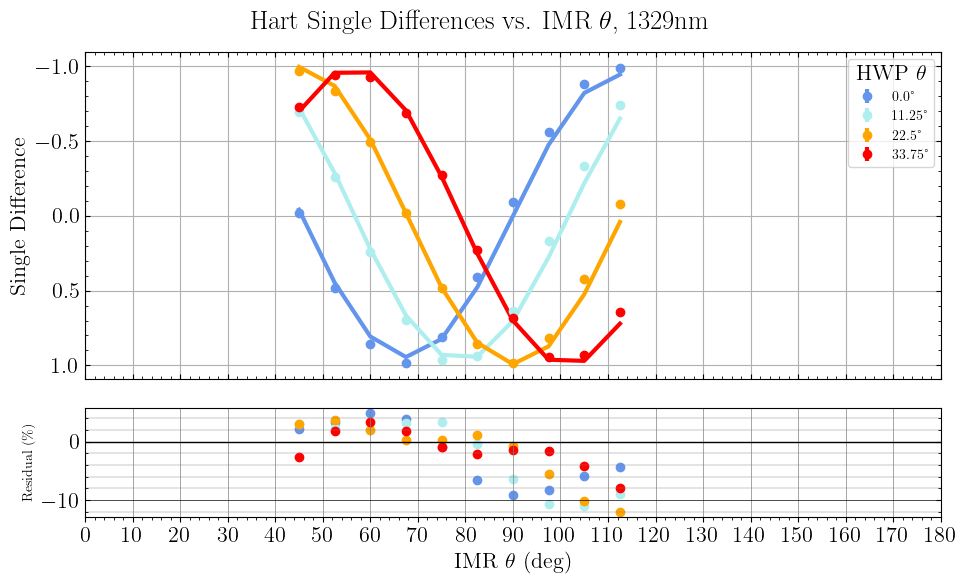

In [70]:
# reproduce Hart data

offset_imr = -0.0118 # derotator offset
offset_hwp = -0.002 # HWP offset
offset_cal = -0.035 # calibration polarizer offset
imr_theta = 0
hwp_theta = 0

# Define instrument configuration as system dictionary
# Wollaston beam, imr theta/phi, and hwp theta/phi will all be updated within functions, so don't worry about their values here

system_dict = {
        "components" : {
            "wollaston" : {
            "type" : "wollaston_prism_function",
            "properties" : {"beam": 'o'}, 
            "tag": "internal",
            },
            "image_rotator" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": imr_theta, "delta_theta": offset_imr},
                "tag": "internal",
            },
            "hwp" : {
                "type" : "general_retarder_function",
                "properties" : {"phi": 0, "theta": hwp_theta, "delta_theta": offset_hwp},
                "tag": "internal",
            },
            "lp" : {  # calibration polarizer for internal calibration source
                "type": "diattenuator_retarder_function",
                "properties": {"theta":-45,"epsilon":1,"delta_theta": offset_cal },
                "tag": "internal",
            }}
    }

# Converting system dictionary into system Mueller Matrix object

system_mm = generate_system_mueller_matrix(system_dict)

# Load in data
filepath = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/hart/csvs/bin4_fixed.csv')
interleaved_values, interleaved_stds, configuration_list = read_csv(filepath)
print("Interleaved Values")


# Get our model retardances from Joost t Hart physical models
wsio2_ = 1.623
wmgf2_ = 1.268
d_ = 262.56
p = [HWP_retardance(wavelength_bins,wsio2_,wmgf2_)[4], IMR_retardance(wavelength_bins,d_)[4]]


# Gefine what is in the p list

system_parameters = [['hwp', 'phi'], ['image_rotator', 'phi']]

# Generate our modeled left and right beam intensities

LR_intensities = model(p, system_parameters, system_mm, configuration_list)

# Process these into interleaved single norm differences and sums

diffs_sums = process_model(LR_intensities, 'CHARIS')

# Plot the modeled and observed values


fig_imr, ax_imr,small_ax = plot_data_and_model_x_imr(interleaved_values, interleaved_stds, diffs_sums,configuration_list, hwp_theta_filter=[0,11.25,22.5,33.75],wavelength= wavelength_bins[4], title=r'Hart Single Differences vs. IMR $\theta$, 1329nm')
ax_imr.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',  # both major and minor
)
ax_imr.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)
# Show minor ticks
ax_imr.minorticks_on()
ax_imr.tick_params(
    axis='x',
    direction='in',
    top=True,
    which='both',
      # both major and minor
)
small_ax.tick_params(
    axis='y',
    direction='in',
    right=True,
    which='both',
)



# Show minor ticks
small_ax.minorticks_on()
#fig_imr.savefig('/Users/thomasmcintosh/Desktop/CHARIS-REU/hart/plots/vs_imr_1575nm.png', bbox_inches='tight', dpi=600)


# Print residuals (will be useful later to see if your fit improved at a quick glance)
residuals = interleaved_values[::2] - diffs_sums[::2]
print("Residuals range:", residuals.min(), residuals.max())


In [72]:
# find differences between hart data and ours
filepath_new = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Data_visualization_3/csvs_nopickoff/charis_cube_info_bin4_no_pickoff.csv')
interleaved_values_new, interleaved_stds_new, configuration_list_new = read_csv(filepath_new)
diffssumsnew = interleaved_values_new
n_derotator = 8
n_hwp = 9

# Get the linear indices (0 to 71) for desired (derotator, hwp) combos
target_linear_indices = []

hart_hwp_order = [4, 5, 6, 7, 0, 1, 2, 3]  # CHARIS order rearranged to match Hart

for derotator_idx in [0, 3]:
    for hwp_idx in hart_hwp_order:
        idx = derotator_idx * n_hwp + hwp_idx
        target_linear_indices.append(idx)
# Now map to interleaved indices (remember: sum at 2*i, diff at 2*i+1)
target_interleaved_indices = []
for i in target_linear_indices:
    target_interleaved_indices.extend([2*i, 2*i+1])

# Extract
subset1 = diffssumsnew[target_interleaved_indices]

diffssumshart = interleaved_values


n_hwp2 = 8
n_derotator2 = 10

# Get linear indices for desired derotator angles
target_linear_indices2 = []

for derotator_idx in [0, 5]:
    for hwp_idx in range(n_hwp2):  # 0 to 7
        idx = derotator_idx * n_hwp2 + hwp_idx
        target_linear_indices2.append(idx)

# Get interleaved indices
target_interleaved_indices2 = []
for i in target_linear_indices2:
    target_interleaved_indices2.extend([2*i, 2*i+1])

# Extract values
subset2 = diffssumshart[target_interleaved_indices2]
subset2=subset2
diffhartvsmine = subset1 - subset2

diffdiffs = diffhartvsmine[::2]
df = pd.DataFrame({"our data":subset1[::2],"hart data": subset2[::2],"difference":diffdiffs})
df


,our data,hart data,difference
0,-0.960918,-0.083053,-0.877865
1,-0.759241,0.621446,-1.380687
2,-0.128311,0.958643,-1.086954
3,0.593541,0.686085,-0.092544
4,0.970755,-0.019485,0.990240
5,0.751564,-0.692167,1.443730
6,0.075464,-0.966470,1.041934
7,-0.629277,-0.724597,0.095319
8,0.881068,-0.507863,1.388931
9,0.305360,-0.944368,1.249727
